In [1]:
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity= 'all'
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
import math
import matplotlib as mpl
import seaborn as sn
sn.set()
import matplotlib.font_manager as fm
fl = fm.FontProperties(fname ="C:\Windows\Fonts\malgun.ttf").get_name()
plt.rc('font',family=fl)
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [4]:
from functions import *
class Relu:
    def __init__(self):
        self.mask = None
    # 순전파
    def forward(self, x):
        self.mask=(x<=0) #참거짓을 가진다는 의미
        out = x.copy()
        out[self.mask] = 0        
        return out
    def backward(self, dout): # dout은 흘러들어온 미분값
        dout[self.mask] = 0
        dx= dout        
        return dx  
    
class Sigmoid:
    def __init__(self):
        self.out = None        
    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out   
    def backward(self, dout):
        dx = dout*(1 - self.out)*self.out # 나갔던 값
        return dx  
    
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b        
        self.x = None
        self.original_x_shape = None        
        self.dw = None
        self.db = None        
    def forward(self,x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0],-1) # 전체의 feature를 보고 그걸 reshape으로 변경
        self.x = x
        out = np.dot(self.x, self.W+self.b)
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)        
        dx = dx.reshape(*self.original_x_shape) # 입력 데이터 모양 변경       
        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss=None
        self.y =None
        self.t = None       
    def forward(self, x, t):
        self.t = t
        self.y =softmax(x)
        self.loss = cross_entropy_error(self.y, self.t) # loss function      
        return self.loss  
    def backward(self, dout =1 ):
        batch_szie = self.t.shape[0]       
        if self.t.size == self.y.size:  ## 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t)/batch_size            
        else:
            dx = self.y.copy()
            dx[np.arrange(batch_size), self.t] -= 1
            dx = dx/batch_size
            
class Dropout:
    def __init__(self, dropout_ratio = 0.2):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    def backward(self, dout):
        return dout* self.mask
    
class SGD:
    def __init__(self, lr=0.01):
        self.lr =lr
    def update(self,params,grads):
        for key in params.keys():
            params[key] -= self.lr*grads[key]
            
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)    
            
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2 = 0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2 
        self.iter = 0
        self.m = None
        self.v = None
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        for key in params.key():
            self.m[key] += (1-self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1-self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
class RMSprop:
    def __init__(self, lr = 0.1, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
        for key, val in params.items():
            self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += ( 1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            
class BatchNormalization:
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None  
        self.running_mean = running_mean
        self.running_var = running_var  
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None   
    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)
        out = self.__forward(x, train_flg)        
        return out.reshape(*self.input_shape)       
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)                       
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))            
        out = self.gamma * xn + self.beta 
        return out
    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)
        dx = self.__backward(dout)
        dx = dx.reshape(*self.input_shape)
        return dx
    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        self.dgamma = dgamma
        self.dbeta = dbeta
        return dx

# 1. 3층 Hidden_Layer 오차역전파를 이용한 MNIST 계산

In [81]:
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict 
class ThreeLayerNet:    
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1']=weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1']=np.zeros(hidden_size1)
        self.params['W2']=weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2']=np.zeros(hidden_size2)
        self.params['W3']=weight_init_std * np.random.randn(hidden_size2, hidden_size3)
        self.params['b3']=np.zeros(hidden_size3)
        self.params['W4']=weight_init_std * np.random.randn(hidden_size3, output_size)
        self.params['b4']=np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['Relu']=Relu() 
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])
        self.layers['Relu']=Relu()
        self.layers['Affine3']=Affine(self.params['W3'],self.params['b3'])
        self.layers['Relu']=Relu()
        self.layers['Affine4']=Affine(self.params['W4'],self.params['b4'])
        
        self.lastlayer = SoftmaxWithLoss()        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)           
        return x    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastlayer.forward(y,t)    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # y값 중에서 가장큰 값의 위치
        if t.ndim != 1 : t=np.argmax(t,axis =1)           
        accuracy = np.sum(y == t)/float(x.shape[0])
        return accuracy
    def numerical_gradient(self, x, t):
        loss_W = lambda W : self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])
        return grads
    def gradient(self, x, t):
        self.loss(x,t)
        dout = 1
        dout = self.lastlayer.backward(dout)            
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)        
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db     
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db  
        return grads

In [82]:
from mnist import load_mnist
(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

network = ThreeLayerNet(input_size = 784, hidden_size1 = 300,hidden_size2 = 100, hidden_size3 = 50, output_size = 10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x1 = []
plt_y1 = []
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch) 
    
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        network.params[key] -= learning_rate*grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x1.append(train_acc)
        plt_y1.append(test_acc)
        print('train :',round(train_acc,3),'//','test :', round(test_acc,3))

train : 0.099 // test : 0.096
train : 0.112 // test : 0.114
train : 0.285 // test : 0.28
train : 0.851 // test : 0.851
train : 0.937 // test : 0.933
train : 0.942 // test : 0.934
train : 0.957 // test : 0.947
train : 0.972 // test : 0.957
train : 0.978 // test : 0.962
train : 0.981 // test : 0.964
train : 0.988 // test : 0.97
train : 0.988 // test : 0.968
train : 0.991 // test : 0.971
train : 0.992 // test : 0.969
train : 0.994 // test : 0.971
train : 0.993 // test : 0.97
train : 0.997 // test : 0.973


# 2. Dropout을 보정해준 MNIST 계산
- hidden_layer가 많아 dropout_ratio를 낮게 설정

In [132]:
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict 
class ThreeLayerNet:  
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1']=weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1']=np.zeros(hidden_size1)
        self.params['W2']=weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2']=np.zeros(hidden_size2)
        self.params['W3']=weight_init_std * np.random.randn(hidden_size2, hidden_size3)
        self.params['b3']=np.zeros(hidden_size3)
        self.params['W4']=weight_init_std * np.random.randn(hidden_size3, output_size)
        self.params['b4']=np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['Relu']=Relu()
        self.layers['dropout1'] = Dropout(dropout_ratio = 0.25)   # dropout 보정
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])
        self.layers['Relu']=Relu()
        self.layers['dropout2'] = Dropout(dropout_ratio = 0.4)   # dropout 보정
        self.layers['Affine3']=Affine(self.params['W3'],self.params['b3'])
        self.layers['Relu']=Relu() 
        self.layers['dropout3'] = Dropout(dropout_ratio = 0.3)   # dropout 보정
        self.layers['Affine4']=Affine(self.params['W4'],self.params['b4'])
        
        self.lastlayer = SoftmaxWithLoss()        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)          
        return x    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastlayer.forward(y,t)   
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1 : t=np.argmax(t,axis =1)          
        accuracy = np.sum(y == t)/float(x.shape[0])
        return accuracy
        
    def numerical_gradient(self, x, t):
        loss_W = lambda W : self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])
        return grads
    def gradient(self, x, t):
        self.loss(x,t)
        dout = 1
        dout = self.lastlayer.backward(dout)            
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)        
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db     
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db  
        return grads

In [133]:
## 학습 및 실행
from mnist import load_mnist
(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

network = ThreeLayerNet(input_size = 784, hidden_size1 = 300, hidden_size2 = 100, hidden_size3 = 50, output_size = 10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x2 = []
plt_y2 = []
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        network.params[key] -= learning_rate*grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x2.append(train_acc)
        plt_y2.append(test_acc)
        print('train :',round(train_acc,3),'//','test :', round(test_acc,3))

train : 0.099 // test : 0.098
train : 0.112 // test : 0.114
train : 0.112 // test : 0.114
train : 0.112 // test : 0.114
train : 0.112 // test : 0.114
train : 0.112 // test : 0.114
train : 0.209 // test : 0.21
train : 0.455 // test : 0.448
train : 0.59 // test : 0.587
train : 0.845 // test : 0.842
train : 0.903 // test : 0.898
train : 0.92 // test : 0.917
train : 0.932 // test : 0.929
train : 0.935 // test : 0.926
train : 0.949 // test : 0.942
train : 0.954 // test : 0.944
train : 0.958 // test : 0.948


# 3. 가중치 초기화를 보정한 MNIST
- Relu이기 때문에 분자가 2

In [69]:
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict 
class ThreeLayerNet:    
    def __init__(self, input_size, hidden_size1,hidden_size2, hidden_size3 , output_size):
        all_size_list = [input_size] + [hidden_size1] + [hidden_size2] + [hidden_size3] + [output_size]
        idx = 4 # 은닉층 3개
        self.params = {}
        self.params['W1']=np.sqrt(2.0/all_size_list[0])*np.random.randn(input_size, hidden_size1)
        self.params['b1']=np.zeros(hidden_size1)
        self.params['W2']=np.sqrt(2.0/all_size_list[1])* np.random.randn(hidden_size1, hidden_size2)
        self.params['b2']=np.zeros(hidden_size2)
        self.params['W3']=np.sqrt(2.0/all_size_list[2])* np.random.randn(hidden_size2, hidden_size3)
        self.params['b3']=np.zeros(hidden_size3)
        self.params['W4']=np.sqrt(2.0/all_size_list[3])* np.random.randn(hidden_size3, output_size)
        self.params['b4']=np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['Relu']=Relu() 
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])
        self.layers['Relu']=Relu()
        self.layers['Affine3']=Affine(self.params['W3'],self.params['b3'])
        self.layers['Relu']=Relu()
        self.layers['Affine4']=Affine(self.params['W4'],self.params['b4'])
        
        self.lastlayer = SoftmaxWithLoss()        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)           
        return x    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastlayer.forward(y,t)    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # y값 중에서 가장큰 값의 위치
        if t.ndim != 1 : t=np.argmax(t,axis =1)           
        accuracy = np.sum(y == t)/float(x.shape[0])
        return accuracy
    def numerical_gradient(self, x, t):
        loss_W = lambda W : self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])
        return grads
    def gradient(self, x, t):
        self.loss(x,t)
        dout = 1
        dout = self.lastlayer.backward(dout)            
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)        
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db
        return grads

In [71]:
## 학습 및 실행
from mnist import load_mnist
(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

network = ThreeLayerNet(input_size = 784, hidden_size1 = 300,hidden_size2 = 100, hidden_size3 = 50, output_size = 10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)

plt_x3 = []
plt_y3 = []
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        network.params[key] -= learning_rate*grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x3.append(train_acc)
        plt_y3.append(test_acc)
        print('train :',round(train_acc,3),'//','test :', round(test_acc,3))

train : 0.248 // test : 0.252
train : 0.955 // test : 0.952
train : 0.972 // test : 0.964
train : 0.978 // test : 0.97
train : 0.986 // test : 0.976
train : 0.99 // test : 0.979
train : 0.992 // test : 0.977
train : 0.993 // test : 0.977
train : 0.994 // test : 0.978
train : 0.996 // test : 0.98
train : 0.998 // test : 0.979
train : 0.998 // test : 0.981
train : 0.999 // test : 0.981
train : 0.997 // test : 0.978
train : 0.999 // test : 0.979
train : 1.0 // test : 0.98
train : 1.0 // test : 0.979


# 4. 배치정규화를 보정해준 MNIST

In [72]:
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict 
class ThreeLayerNet:    
    def __init__(self, input_size, hidden_size1,hidden_size2, hidden_size3 , output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1']=weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1']=np.zeros(hidden_size1)
        self.params['W2']=weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2']=np.zeros(hidden_size2)
        self.params['W3']=weight_init_std * np.random.randn(hidden_size2, hidden_size3)
        self.params['b3']=np.zeros(hidden_size3)
        self.params['W4']=weight_init_std * np.random.randn(hidden_size3, output_size)
        self.params['b4']=np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['BatchNorm1'] = BatchNormalization(gamma=1.0, beta=0.)
        self.layers['Relu']=Relu() 
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])
        self.layers['BatchNorm2'] = BatchNormalization(gamma=1.0, beta=0.)
        self.layers['Relu']=Relu()
        self.layers['Affine3']=Affine(self.params['W3'],self.params['b3'])
        self.layers['BatchNorm3'] = BatchNormalization(gamma=1.0, beta=0.)
        self.layers['Relu']=Relu()
        self.layers['Affine4']=Affine(self.params['W4'],self.params['b4'])
        
        self.lastlayer = SoftmaxWithLoss()        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)           
        return x    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastlayer.forward(y,t)    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # y값 중에서 가장큰 값의 위치
        if t.ndim != 1 : t=np.argmax(t,axis =1)           
        accuracy = np.sum(y == t)/float(x.shape[0])
        return accuracy
    def numerical_gradient(self, x, t):
        loss_W = lambda W : self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])
        return grads
    def gradient(self, x, t):
        self.loss(x,t)
        dout = 1
        dout = self.lastlayer.backward(dout)            
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)        
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db 
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db
        return grads

In [74]:
from mnist import load_mnist
(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

network = ThreeLayerNet(input_size = 784, hidden_size1 = 300,hidden_size2 = 100, hidden_size3 = 50, output_size = 10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x4 = []
plt_y4 = []
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        network.params[key] -= learning_rate*grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x4.append(train_acc)
        plt_y4.append(test_acc)
        print('train :',round(train_acc,3),'//','test :', round(test_acc,3))

train : 0.349 // test : 0.367
train : 0.965 // test : 0.96
train : 0.979 // test : 0.974
train : 0.984 // test : 0.977
train : 0.985 // test : 0.976
train : 0.988 // test : 0.974
train : 0.99 // test : 0.976
train : 0.993 // test : 0.979
train : 0.992 // test : 0.976
train : 0.992 // test : 0.977
train : 0.993 // test : 0.976
train : 0.994 // test : 0.979
train : 0.996 // test : 0.98
train : 0.995 // test : 0.977
train : 0.997 // test : 0.979
train : 0.994 // test : 0.977
train : 0.997 // test : 0.981


# Momentum, AdaGrad, Adam 을 이용한 MNIST

In [5]:
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict 
class ThreeLayerNet:    
    def __init__(self, input_size, hidden_size1,hidden_size2, hidden_size3, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1']=weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1']=np.zeros(hidden_size1)
        self.params['W2']=weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2']=np.zeros(hidden_size2)
        self.params['W3']=weight_init_std * np.random.randn(hidden_size2, hidden_size3)
        self.params['b3']=np.zeros(hidden_size3)
        self.params['W4']=weight_init_std * np.random.randn(hidden_size3, output_size)
        self.params['b4']=np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['Relu']=Relu() 
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])
        self.layers['Relu']=Relu()
        self.layers['Affine3']=Affine(self.params['W3'],self.params['b3'])
        self.layers['Relu']=Relu() 
        self.layers['Affine4']=Affine(self.params['W4'],self.params['b4'])
        
        self.lastlayer = SoftmaxWithLoss()        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)           
        return x    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastlayer.forward(y,t)    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # y값 중에서 가장큰 값의 위치
        if t.ndim != 1 : t=np.argmax(t,axis =1)           
        accuracy = np.sum(y == t)/float(x.shape[0])
        return accuracy
    def numerical_gradient(self, x, t):
        loss_W = lambda W : self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])         
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])        
        return grads
    def gradient(self, x, t):
        self.loss(x,t)
        dout = 1
        dout = self.lastlayer.backward(dout)            
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)        
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db      
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db 
        return grads

===========iteration:0===========
SGD:2.3845512939312337
Momentum:2.4100689035318283
AdaGrad:4.708257347845251
Adam:2.07576421812051
===========iteration:200===========
SGD:0.5869670849184702
Momentum:0.32572828009927124
AdaGrad:0.13715473958219565
Adam:0.23675314714256657
===========iteration:400===========
SGD:0.5028422842218354
Momentum:0.20565599257001885
AdaGrad:0.08896194101553176
Adam:0.17877078026929344
===========iteration:600===========
SGD:0.35967776352839115
Momentum:0.09817621910315111
AdaGrad:0.03944847358242747
Adam:0.06269732156820523
===========iteration:800===========
SGD:0.24513637988781997
Momentum:0.11337995095943487
AdaGrad:0.06676889287235824
Adam:0.05597613242614094
===========iteration:1000===========
SGD:0.4161336656254055
Momentum:0.09713149879828097
AdaGrad:0.05585435806744833
Adam:0.07953363291229197
===========iteration:1200===========
SGD:0.25443245640562234
Momentum:0.04872706498790052
AdaGrad:0.022770040419371723
Adam:0.041405045483447464
===========ite

Text(0.5, 0, 'iterations')

Text(0, 0.5, 'loss')

(0, 2)

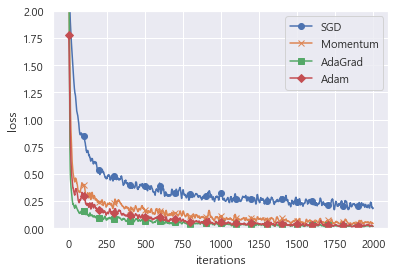

In [141]:
import os
import sys
sys.path.append(os.pardir)
from util import smooth_curve
from multi_layer_net import MultiLayerNet
from optimizer import *

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
train_size = x_train.shape[0]
batch_size = 100
max_iterations = 2000

optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = ThreeLayerNet(input_size = 784, hidden_size1 = 300,hidden_size2 = 100, hidden_size3 = 50, output_size = 10)
    train_loss[key] = []    

for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 200 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2)
plt.legend()
plt.show()

# 5. Momentum으로 계산한 MNIST

In [90]:
from mnist import load_mnist
(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

network = ThreeLayerNet(input_size = 784, hidden_size1 = 300,hidden_size2 = 100, hidden_size3 = 50, output_size = 10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
momentum = 0.9
v = None

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x5 = []
plt_y5 = []
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    if v is None:
        v = {}
        for key, val in network.params.items():
            v[key] = np.zeros_like(val)
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        v[key] = momentum * v[key] - learning_rate * grad[key]
        network.params[key] += v[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x5.append(train_acc)
        plt_y5.append(test_acc)
        print('train :',round(train_acc,3),'//','test :', round(test_acc,3))

train : 0.103 // test : 0.102
train : 0.112 // test : 0.114
train : 0.112 // test : 0.114
train : 0.112 // test : 0.114
train : 0.112 // test : 0.114
train : 0.668 // test : 0.671
train : 0.884 // test : 0.883
train : 0.913 // test : 0.91
train : 0.93 // test : 0.928
train : 0.942 // test : 0.94
train : 0.948 // test : 0.945
train : 0.954 // test : 0.949
train : 0.957 // test : 0.952
train : 0.96 // test : 0.949
train : 0.962 // test : 0.957
train : 0.965 // test : 0.954
train : 0.968 // test : 0.96


# 6. Adam으로 계산한 MNIST

In [91]:
from mnist import load_mnist
(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

network = ThreeLayerNet(input_size = 784, hidden_size1 = 300,hidden_size2 = 100, hidden_size3 = 50, output_size = 10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
v = None
m = None
_iter = 0

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x6 = []
plt_y6 = []
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    if m is None:
        v = {}
        m = {}
        for key, val in network.params.items():
            v[key] = np.zeros_like(val)
            m[key] = np.zeros_like(val)
    _iter += 1
    lr_t = learning_rate * np.sqrt(1.0 - beta2**_iter) / (1.0 - beta1**_iter)
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        m[key] += (1 - beta1)*(grad[key] - m[key])
        v[key] += (1 - beta2)*(grad[key]**2 - v[key])
        network.params[key] -= lr_t * m[key] / (np.sqrt(v[key]) + 1e-7)
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x6.append(train_acc)
        plt_y6.append(test_acc)
        print('train :',round(train_acc,3),'//','test :', round(test_acc,3))

train : 0.164 // test : 0.169
train : 0.922 // test : 0.922
train : 0.945 // test : 0.944
train : 0.955 // test : 0.952
train : 0.96 // test : 0.949
train : 0.961 // test : 0.952
train : 0.964 // test : 0.957
train : 0.967 // test : 0.958
train : 0.972 // test : 0.963
train : 0.971 // test : 0.961
train : 0.973 // test : 0.962
train : 0.974 // test : 0.964
train : 0.977 // test : 0.965
train : 0.974 // test : 0.962
train : 0.978 // test : 0.966
train : 0.978 // test : 0.964
train : 0.977 // test : 0.965


# 7. AdaGrad로 계산한 MNIST

In [103]:
from mnist import load_mnist
(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

network = ThreeLayerNet(input_size = 784, hidden_size1 = 300,hidden_size2 = 100, hidden_size3 = 50, output_size = 10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
h = None

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x7 = []
plt_y7 = []
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    if h is None:
        h = {}
        for key, val in network.params.items():
            h[key] = np.zeros_like(val)
            
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        h[key] += (grad[key])*(grad[key])
        network.params[key] -= learning_rate * grad[key] / (np.sqrt(h[key]) + 1e-7)
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x7.append(train_acc)
        plt_y7.append(test_acc)
        print('train :',round(train_acc,3),'//','test :', round(test_acc,3))

train : 0.158 // test : 0.157
train : 0.951 // test : 0.945
train : 0.965 // test : 0.958
train : 0.972 // test : 0.966
train : 0.976 // test : 0.968
train : 0.98 // test : 0.97
train : 0.983 // test : 0.972
train : 0.985 // test : 0.972
train : 0.986 // test : 0.975
train : 0.988 // test : 0.975
train : 0.989 // test : 0.975
train : 0.99 // test : 0.973
train : 0.992 // test : 0.976
train : 0.993 // test : 0.975
train : 0.994 // test : 0.976
train : 0.995 // test : 0.977
train : 0.995 // test : 0.977


## 최적의 학습법을 찾기위해 test값의 마지막 5개 값의 평균을 구한뒤 비교

In [152]:
print('아무것도 적용하지 않은 오차역전파 MNIST :',np.mean(plt_y1[12:]))
print('Dropout을 적용한 MNIST :',np.mean(plt_y2[12:]))
print('가중치 초기화를 적용한 MNIST :',np.mean(plt_y3[12:]))
print('배치정규화를 적용한 MNIST :',np.mean(plt_y4[12:]))
print('=============================================')
print('Momentum을 적용한 MNIST :',np.mean(plt_y5[12:]))
print('Adam을 적용한 MNIST :',np.mean(plt_y6[12:]))
print('AdaGrad를 적용한 MNIST :',np.mean(plt_y7[12:]))

아무것도 적용하지 않은 오차역전파 MNIST : 0.97068
Dropout을 적용한 MNIST : 0.93794
가중치 초기화를 적용한 MNIST : 0.9795999999999999
배치정규화를 적용한 MNIST : 0.9786800000000001
Momentum을 적용한 MNIST : 0.95448
Adam을 적용한 MNIST : 0.9642
AdaGrad를 적용한 MNIST : 0.9761599999999999


# 8. 가중치 초기화 + 배치정규화 + AdaGrad

In [147]:
from layers import *
from gradient import numerical_gradient
from collections import OrderedDict 
class ThreeLayerNet:    
    def __init__(self, input_size, hidden_size1,hidden_size2, hidden_size3 , output_size):
        all_size_list = [input_size] + [hidden_size1] + [hidden_size2] + [hidden_size3] + [output_size]
        idx = 4 # 은닉층 3개
        self.params = {}
        self.params['W1']=np.sqrt(2.0/all_size_list[0])*np.random.randn(input_size, hidden_size1)
        self.params['b1']=np.zeros(hidden_size1)
        self.params['W2']=np.sqrt(2.0/all_size_list[1])* np.random.randn(hidden_size1, hidden_size2)
        self.params['b2']=np.zeros(hidden_size2)
        self.params['W3']=np.sqrt(2.0/all_size_list[2])* np.random.randn(hidden_size2, hidden_size3)
        self.params['b3']=np.zeros(hidden_size3)
        self.params['W4']=np.sqrt(2.0/all_size_list[3])* np.random.randn(hidden_size3, output_size)
        self.params['b4']=np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1']=Affine(self.params['W1'],self.params['b1'])
        self.layers['BatchNorm1'] = BatchNormalization(gamma=1.0, beta=0.)
        self.layers['Relu']=Relu() 
        self.layers['Affine2']=Affine(self.params['W2'],self.params['b2'])
        self.layers['BatchNorm2'] = BatchNormalization(gamma=1.0, beta=0.)
        self.layers['Relu']=Relu()
        self.layers['Affine3']=Affine(self.params['W3'],self.params['b3'])
        self.layers['BatchNorm3'] = BatchNormalization(gamma=1.0, beta=0.)
        self.layers['Relu']=Relu()
        self.layers['Affine4']=Affine(self.params['W4'],self.params['b4'])
        
        self.lastlayer = SoftmaxWithLoss()        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)           
        return x    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastlayer.forward(y,t)    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # y값 중에서 가장큰 값의 위치
        if t.ndim != 1 : t=np.argmax(t,axis =1)           
        accuracy = np.sum(y == t)/float(x.shape[0])
        return accuracy
    def numerical_gradient(self, x, t):
        loss_W = lambda W : self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        grads['W4'] = numerical_gradient(loss_W, self.params['W4'])
        grads['b4'] = numerical_gradient(loss_W, self.params['b4'])
        return grads
    def gradient(self, x, t):
        self.loss(x,t)
        dout = 1
        dout = self.lastlayer.backward(dout)            
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)        
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db
        return grads

In [148]:
from mnist import load_mnist
(x_train, t_train), (x_test, t_test)= load_mnist(normalize =True, one_hot_label = True)

network = ThreeLayerNet(input_size = 784, hidden_size1 = 300,hidden_size2 = 100, hidden_size3 = 50, output_size = 10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
h = None

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size , 1)
plt_x8 = []
plt_y8 = []
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch) 
    
    if h is None:
        h = {}
        for key, val in network.params.items():
            h[key] = np.zeros_like(val)
            
    for key in ('W1','b1','W2','b2','W3','b3','W4','b4'):
        h[key] += (grad[key])*(grad[key])
        network.params[key] -= learning_rate * grad[key] / (np.sqrt(h[key]) + 1e-7)
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        plt_x8.append(train_acc)
        plt_y8.append(test_acc)
        print('train :',round(train_acc,3),'//','test :', round(test_acc,3))

train : 0.666 // test : 0.67
train : 0.976 // test : 0.968
train : 0.987 // test : 0.974
train : 0.991 // test : 0.978
train : 0.994 // test : 0.98
train : 0.996 // test : 0.979
train : 0.997 // test : 0.98
train : 0.998 // test : 0.98
train : 0.998 // test : 0.98
train : 0.999 // test : 0.981
train : 0.999 // test : 0.982
train : 0.999 // test : 0.981
train : 0.999 // test : 0.981
train : 0.999 // test : 0.982
train : 1.0 // test : 0.982
train : 1.0 // test : 0.981
train : 1.0 // test : 0.981


## accuracy 값이 가장 잘나왔던 방법 3가지를 서로 섞어서 학습하였더니 train값에서 1.0이 나와 과대적합을 의심할 수 있으나 test값에서도 안정적으로 test값이 9.8이 나왔다.

Text(0.5, 1.0, '오차역전파')

Text(0.5, 1.0, 'Dropout')

Text(0.5, 1.0, '가중치 초기화')

Text(0.5, 1.0, '배치정규화')

Text(0.5, 1.0, 'Momentum')

Text(0.5, 1.0, 'Adam')

Text(0.5, 1.0, 'AdaGrad')

Text(0.5, 1.0, '가중치 초기화 + 배치정규화 + AdaGrad')

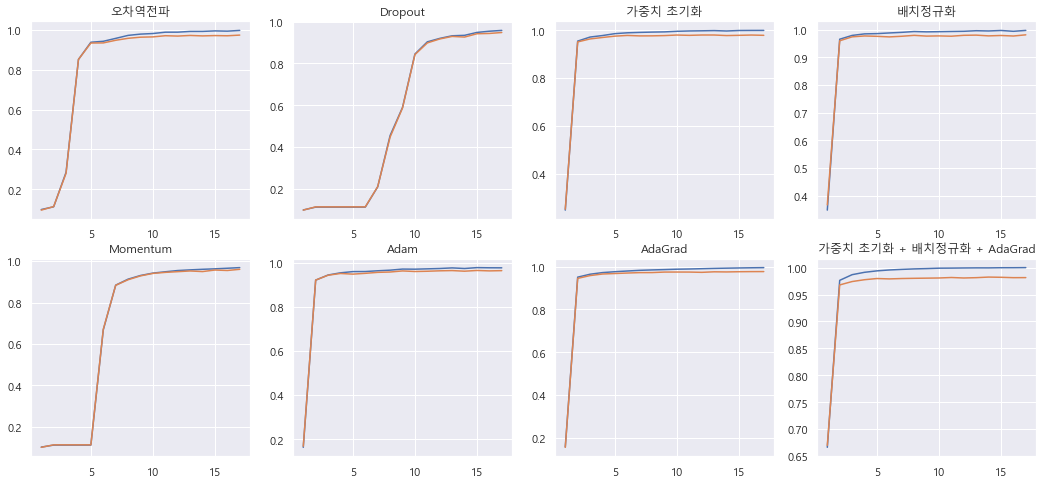

In [154]:
plt_x = np.arange(1,18)
fig, ax = plt.subplots(2,4, figsize =(18,8))
ax[0,0].plot(plt_x,plt_x1)
ax[0,0].plot(plt_x,plt_y1)
ax[0,0].set_title('오차역전파')
ax[0,1].plot(plt_x,plt_x2)
ax[0,1].plot(plt_x,plt_y2)
ax[0,1].set_title('Dropout')
ax[0,2].plot(plt_x,plt_x3)
ax[0,2].plot(plt_x,plt_y3)
ax[0,2].set_title('가중치 초기화')
ax[0,3].plot(plt_x,plt_x4)
ax[0,3].plot(plt_x,plt_y4)
ax[0,3].set_title('배치정규화')
ax[1,0].plot(plt_x,plt_x5)
ax[1,0].plot(plt_x,plt_y5)
ax[1,0].set_title('Momentum')
ax[1,1].plot(plt_x,plt_x6)
ax[1,1].plot(plt_x,plt_y6)
ax[1,1].set_title('Adam')
ax[1,2].plot(plt_x,plt_x7)
ax[1,2].plot(plt_x,plt_y7)
ax[1,2].set_title('AdaGrad')
ax[1,3].plot(plt_x,plt_x8)
ax[1,3].plot(plt_x,plt_y8)
ax[1,3].set_title('가중치 초기화 + 배치정규화 + AdaGrad')
plt.show()